##  Load packages and configure GPU

In [1]:
#!pip install tensorflow-models-official

In [1]:
import tensorflow as tf
import os, sys
import warnings
from cholect50 import dataloader_tf as dataloader
import matplotlib.pyplot as plt
import numpy as np

#os.environ['PYTHONPATH'] += ":/code/models"

#import tensorflow_models as tfm
#from tensorflow_models import vision
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, ConvLSTM2D, TimeDistributed
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Layer
import tensorflow_addons as tfa

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings("ignore")
%matplotlib inline

2023-05-03 23:03:51.468108: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 23:03:52.312635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mainuser/.local/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[1],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*24)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


2023-05-03 23:04:01.749586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 55659 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0001:00:00.0, compute capability: 8.0
2023-05-03 23:04:01.751821: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 24576 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0002:00:00.0, compute capability: 8.0


## Load train, test, val dataset using the Dataloader 

In [5]:
BATCH_SIZE = 8
SEQUENCE_DEPTH = 16

In [4]:
dataset = dataloader.CholecT50( 
          dataset_dir="CholecT50", 
          dataset_variant="cholect50",
          test_fold=1,
          augmentation_list=['original'],
          num_parallel_calls=100,
          num_sequence = SEQUENCE_DEPTH
          )

# build dataset
train_dataset, val_dataset, test_dataset = dataset.build()

# train and val data loaders
train_dataloader = train_dataset.batch(BATCH_SIZE) # see tf.data.Dataset for more options
val_dataloader   = val_dataset.batch(BATCH_SIZE)

# test data set is built per video, so load differently
test_dataloaders = []
for video_dataset in test_dataset:
    test_dataloader = video_dataset.batch(BATCH_SIZE)
    test_dataloaders.append(test_dataloader)  

## Inspect Dataset

2023-05-03 23:04:40.251451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


(8, 16, 256, 448, 3)
(16, 256, 448, 3)


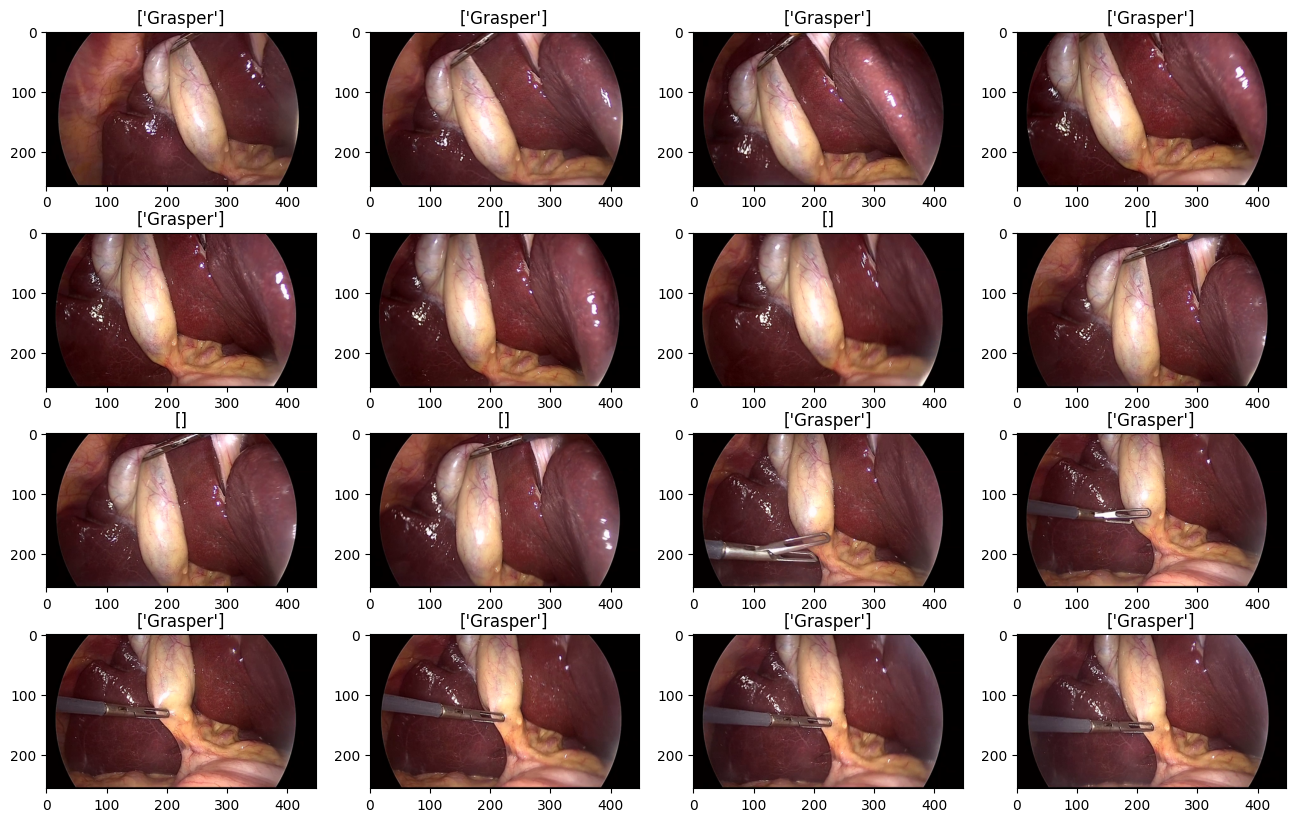

In [6]:
# Given instruments in the dataset
instruments = np.array([
    "Grasper",
    "Bipolar",
    "Hook",
    "Scissors",
    "Clipper",
    "Irrigator"
])

# Take 1 batch of image sequences from the train_dataloader
for (img_list, (ivt_list, i_list, v_list, t_list, p_list)) in train_dataloader.take(1):
    break
    
print(img_list.shape)

# Print sequence of images in a single batch
img_seq = img_list[0]
label_seq = i_list[0]

print(img_seq.shape)

plt.subplots(4,4,figsize=(16,10))

for idx in range(0, SEQUENCE_DEPTH):
    img = img_seq[idx].numpy()
    label = instruments[label_seq[idx] == 1]
    plt.subplot(4,4,idx+1)
    plt.imshow(img.astype(np.uint8))
    plt.title(str(label))